### Section 0: Data Preprocessing

Import Libraries

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sentiment140:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2477%2F4140%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240501%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240501T002711Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D17e3689186fa40cf932f79f0529acc322c495ae05b1f5dbf2279d60d60d4155e28beb3c22063169f76e8cfed9a7653f2fdadd665fe0a1b70ae6c11fe620b3ce41bafcc69364f1bdb90157d087cac8f6b36a4f80766edfbefdd86febe3879794f6e24a7423e9a46473f64ecfbb3b3f06e2acf45b185600be9a3e8d0b0d0fcc6afe54e2c86a00815bf3a2dacfcd5d85d7b03f2a6ee0200629963775be61d52850077675b0d97a20678896a774384e3d06a343a19e241d3bdda67469f40490b56c6df865b21234bc629359962b5bc4e55153d38531a901be81c2fc2e783326656f714e56559f5c112589c6668b8bf0cfb1ab5d24370e36b31eb990b1e0047c3c1ca'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 84855679 bytes downloaded
Downloaded and uncompressed: sentiment140
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Load Data

In [ ]:
data = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]

Data Overview

In [ ]:
print(data.head())
print(data.tail())
print(data.columns)
print('lenght of data is', len(data))
print(data.shape)
print(data.info())
print(data.dtypes)

   label        time                          date     query       username  \
0      0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY  scotthamilton   
1      0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY       mattycus   
2      0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY        ElleCTF   
3      0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         Karoli   
4      0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY       joy_wolf   

                                                text  
0  is upset that he can't update his Facebook by ...  
1  @Kenichan I dived many times for the ball. Man...  
2    my whole body feels itchy and like its on fire   
3  @nationwideclass no, it's not behaving at all....  
4                      @Kwesidei not the whole crew   
         label        time                          date     query  \
1599994      4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599995      4  2193601969  Tue Jun 16 08:40:49 PDT 200

In [ ]:
# Check missing data
np.sum(data.isnull().any(axis=1))

0

In [ ]:
print('Count of columns in the data is:  ', len(data.columns))
print('Count of rows in the data is:  ', len(data))

Count of columns in the data is:   6
Count of rows in the data is:   1599999


In [ ]:
# Check whether there is neutral sentiment with numerical label '2'
if (data['label'] == 2).any():
    print("There are values equal to 2 in the 'label' column.")
else:
    print("There are no values equal to 2 in the 'label' column.")

There are no values equal to 2 in the 'label' column.


Data Cleaning and Preparation

In [ ]:
# Select the 'text' and 'label' columns
data=data[['text','label']]
# Modify 'label' column, turn label to binary form (Positive Sentiment = 1, Negative Sentiment = 0)
data['label'][data['label']==4] = 1
# Separating positive and negative tweets
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

In [ ]:
# Limit the number of both positive and negative tweets dataset to 20,000
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [ ]:
# Combine positive and negative tweets as training dataset
data = pd.concat([data_pos, data_neg])

### Section 1: Change Tokenization (Word-level vs Bi-gram vs Tri-gram)

#### Method 1: Word-level Tokenization

Model-Specific Preprocessing

In [ ]:
# Make text in lower case
data['text']=data['text'].str.lower()
data['text'].tail()

19995                            one more day of holidays 
19996    feeling so down right now .. i hate you damn h...
19997    geez,i hv to read the whole book of personalit...
19998    i threw my sign at donnie and he bent over to ...
19999    @heather2711 good thing i didn't find any then...
Name: text, dtype: object

In [ ]:
# Stopwords list provided by NLTK (common English words that are often filtered out)
nltk.download('stopwords')
stopwords_list = stopwords.words('english')
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
# Remove the stopwords
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))

In [ ]:
# Remove the punctuations
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))

In [ ]:
# Remove repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))

# Remove email
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)
data['text']= data['text'].apply(lambda x: cleaning_email(x))

# Remove URL's
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))

# Remove numeric numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))

Tokenization

In [ ]:
# Create a tokenizer that divide text into word sequences, ignoring spaces, punctuation, and other non-word elements
tokenizer = RegexpTokenizer(r'\w+')
# Process each tweet to produce a list of word tokens
data['text'] = data['text'].apply(tokenizer.tokenize)

In [ ]:
# Apply Stemming: Reduce words to their base form by removing inflectional endings
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return text

data['text']= data['text'].apply(lambda x: stemming_on_text(x))

In [ ]:
# Apply Lemmatization: Reduce words to their dictionary form to achieve more accurate root form
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return text

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Separate feature and label
X = data.text
y = data.label

In [ ]:
# Max features per input sample
max_len = 500
# Tokenizer: choose the most frequent 2000 words (vocabulary size) from all tweet samples
tok = Tokenizer(num_words=2000)
# Fit tokenizer to dataset with all tweet samples, indexing words by frequency (most frequent gets index 1), build a tokenizer's vocabulary
tok.fit_on_texts(X)
# Convert texts in dataset to sequences of integers based on the tokenizer's vocabulary
sequences = tok.texts_to_sequences(X)
# Padded or Truncated each sample (sequence of integers) to have a length fo 500 tokens
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
# Check the shape of processed dataset
sequences_matrix.shape

(40000, 500)

Prepare Train & Test Dataset

In [ ]:
# Separate 70% training dataset and 30% testing dataset
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size = 0.3, random_state = 2)

Configure Model for Binary Classification

In [ ]:
def tensorflow_based_model():
  # Input Layer (500 features for each sample)
  inputs = Input(name='inputs',shape=[max_len])
  # Embedding Layer to transform the input data (indices representing words) into dense vectors of size 300
  # Every word is converted into a 300-dimensional vector
  layer = Embedding(2000,300,input_length=max_len)(inputs)
  # LSTM layer with 64 units to process sequence data
  layer = LSTM(64)(layer)
  # Fully connected layer with 256 neurons followed by a ReLU activation function for non-linear transformation
  layer = Dense(256,name='FC1')(layer)
  layer = Activation('relu')(layer)
  # Incorporates dropout layer with a rate of 0.5 to reduce overfitting by randomly setting input units to 0 during training
  layer = Dropout(0.5)(layer)
  # Dense layer consisting of a single neuron with a sigmoid activation function to output the probability for the binary classification
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  # Construct the model
  model = Model(inputs=inputs,outputs=layer)
  return model

model = tensorflow_based_model()
# Configure the model for training by setting loss function, learning rate optimizer, and evaluation metrics
model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(), metrics = ['accuracy'])

Train Model

In [ ]:
# Train the model with training dataset
history=model.fit(X_train,Y_train, batch_size = 2000, epochs = 20, validation_split = 0.1)
print('Training finished !!')

Epoch 1/20
13/13 [==============================] - 6s 332ms/step - loss: 0.6921 - accuracy: 0.5271 - val_loss: 0.6911 - val_accuracy: 0.5382
Epoch 2/20
13/13 [==============================] - 4s 304ms/step - loss: 0.6890 - accuracy: 0.5547 - val_loss: 0.6868 - val_accuracy: 0.5632
Epoch 3/20
13/13 [==============================] - 4s 302ms/step - loss: 0.6813 - accuracy: 0.5849 - val_loss: 0.6724 - val_accuracy: 0.6279
Epoch 4/20
13/13 [==============================] - 4s 298ms/step - loss: 0.6622 - accuracy: 0.6296 - val_loss: 0.6557 - val_accuracy: 0.6068
Epoch 5/20
13/13 [==============================] - 4s 302ms/step - loss: 0.6276 - accuracy: 0.6689 - val_loss: 0.6036 - val_accuracy: 0.6793
Epoch 6/20
13/13 [==============================] - 4s 304ms/step - loss: 0.5867 - accuracy: 0.6967 - val_loss: 0.5597 - val_accuracy: 0.7236
Epoch 7/20
13/13 [==============================] - 4s 307ms/step - loss: 0.5494 - accuracy: 0.7287 - val_loss: 0.5369 - val_accuracy: 0.7296
Epoch 

Access Performance

In [ ]:
# Access performance
accr1 = model.evaluate(X_test,Y_test)
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1]))

375/375 [==============================] - 4s 10ms/step - loss: 0.5276 - accuracy: 0.7418
Test set
  Accuracy: 0.74


#### Method 2: Bi-gram

In [ ]:
data['text']=data['text'].str.lower()
data['text'].tail()

19995                            one more day of holidays 
19996    feeling so down right now .. i hate you damn h...
19997    geez,i hv to read the whole book of personalit...
19998    i threw my sign at donnie and he bent over to ...
19999    @heather2711 good thing i didn't find any then...
Name: text, dtype: object

In [ ]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))

def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)
data['text']= data['text'].apply(lambda x: cleaning_email(x))

def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))

In [ ]:
X=data.text
y=data.label

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import bigrams
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def create_bigrams(texts):
    bigram_texts = []
    for text in texts:
        tokens = word_tokenize(text.lower())  # Tokenizing the cleaned text
        bi_tokens = bigrams(tokens)
        bigram_texts.append(' '.join(['_'.join(token) for token in bi_tokens]))
    return bigram_texts

In [ ]:
# Apply bigram creation on the cleaned texts
X_bigrams = create_bigrams(data['text'].tolist())

# Tokenization and Padding
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X_bigrams)
sequences = tok.texts_to_sequences(X_bigrams)
sequences_matrix = pad_sequences(sequences, maxlen=max_len)

In [ ]:
sequences_matrix.shape

(40000, 500)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [ ]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,300,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [ ]:
history=model.fit(X_train,Y_train,batch_size=2000,epochs=20, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/20
13/13 [==============================] - 7s 356ms/step - loss: 0.6914 - accuracy: 0.5414 - val_loss: 0.6883 - val_accuracy: 0.5879
Epoch 2/20
13/13 [==============================] - 4s 293ms/step - loss: 0.6813 - accuracy: 0.5939 - val_loss: 0.6660 - val_accuracy: 0.6171
Epoch 3/20
13/13 [==============================] - 4s 296ms/step - loss: 0.6512 - accuracy: 0.6339 - val_loss: 0.6242 - val_accuracy: 0.6746
Epoch 4/20
13/13 [==============================] - 4s 305ms/step - loss: 0.6071 - accuracy: 0.6799 - val_loss: 0.5940 - val_accuracy: 0.6843
Epoch 5/20
13/13 [==============================] - 4s 301ms/step - loss: 0.5748 - accuracy: 0.7074 - val_loss: 0.5677 - val_accuracy: 0.7075
Epoch 6/20
13/13 [==============================] - 4s 301ms/step - loss: 0.5488 - accuracy: 0.7274 - val_loss: 0.5391 - val_accuracy: 0.7282
Epoch 7/20
13/13 [==============================] - 4s 309ms/step - loss: 0.5291 - accuracy: 0.7448 - val_loss: 0.5567 - val_accuracy: 0.7118
Epoch 

In [ ]:
accr1 = model.evaluate(X_test,Y_test)
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1]))

375/375 [==============================] - 3s 9ms/step - loss: 0.4995 - accuracy: 0.7682
Test set
  Accuracy: 0.77


#### Method 3: Tri-gram

In [ ]:
data['text']=data['text'].str.lower()
data['text'].tail()

19995                            one more day of holidays 
19996    feeling so down right now .. i hate you damn h...
19997    geez,i hv to read the whole book of personalit...
19998    i threw my sign at donnie and he bent over to ...
19999    @heather2711 good thing i didn't find any then...
Name: text, dtype: object

In [ ]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))

def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)
data['text']= data['text'].apply(lambda x: cleaning_email(x))

def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))

In [ ]:
X=data.text
y=data.label

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import trigrams  # Import the trigrams function
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def create_trigrams(texts):
    trigram_texts = []
    for text in texts:
        tokens = word_tokenize(text.lower())  # Tokenizing the cleaned text
        tri_tokens = trigrams(tokens)
        trigram_texts.append(' '.join(['_'.join(token) for token in tri_tokens]))
    return trigram_texts

In [ ]:
# Apply trigram creation on the cleaned texts
X_trigrams = create_trigrams(data['text'].tolist())

# Tokenization and Padding
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X_trigrams)
sequences = tok.texts_to_sequences(X_trigrams)
sequences_matrix = pad_sequences(sequences, maxlen=max_len)

In [ ]:
sequences_matrix.shape

(40000, 500)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [ ]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,300,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [ ]:
history=model.fit(X_train,Y_train,batch_size=2000,epochs=20, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/20
13/13 [==============================] - 7s 357ms/step - loss: 0.6923 - accuracy: 0.5238 - val_loss: 0.6908 - val_accuracy: 0.5657
Epoch 2/20
13/13 [==============================] - 4s 293ms/step - loss: 0.6871 - accuracy: 0.5780 - val_loss: 0.6803 - val_accuracy: 0.5925
Epoch 3/20
13/13 [==============================] - 4s 296ms/step - loss: 0.6637 - accuracy: 0.6187 - val_loss: 0.6339 - val_accuracy: 0.6682
Epoch 4/20
13/13 [==============================] - 4s 304ms/step - loss: 0.6221 - accuracy: 0.6626 - val_loss: 0.5968 - val_accuracy: 0.6893
Epoch 5/20
13/13 [==============================] - 4s 300ms/step - loss: 0.5856 - accuracy: 0.6977 - val_loss: 0.5726 - val_accuracy: 0.7032
Epoch 6/20
13/13 [==============================] - 4s 300ms/step - loss: 0.5599 - accuracy: 0.7206 - val_loss: 0.5795 - val_accuracy: 0.6850
Epoch 7/20
13/13 [==============================] - 4s 311ms/step - loss: 0.5398 - accuracy: 0.7362 - val_loss: 0.5775 - val_accuracy: 0.7093
Epoch 

In [ ]:
accr1 = model.evaluate(X_test,Y_test)
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1]))

375/375 [==============================] - 3s 9ms/step - loss: 0.5129 - accuracy: 0.7554
Test set
  Accuracy: 0.76


According to the result of....

### Section 2: Using Bi-gram, consider Random initialized embedding vs Word2Vec(Trainable) vs Word2Vec(Non-trainable)

#### Method 2: Word2Vec Trainable

In [ ]:
from gensim.models import KeyedVectors
import numpy as np
import gensim.downloader as api

word_vectors = api.load("word2vec-google-news-300")

embedding_matrix = np.zeros((2000, 300))  # 2000 is vocab size, 300 is the dimension of Word2Vec vectors

for bigram, i in tok.word_index.items():
    if i < 2000:  # Only consider the top 2000 words in the vocabulary
        try:
            embedding_vector = word_vectors[bigram]  # Get the embedding vector for the word
            embedding_matrix[i] = embedding_vector  # Assign it to the embedding matrix
        except KeyError:
            # Words not found in the embedding index will be all zeros.
            pass

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Activation, Dropout

def tensorflow_based_model():
    inputs = Input(name='inputs', shape=[max_len])
    # Replace the original Embedding layer with the pre-trained Word2Vec embeddings
    layer = Embedding(2000, 300, input_length=max_len, weights=[embedding_matrix], trainable=True)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [ ]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [ ]:
history=model.fit(X_train,Y_train,batch_size=2000,epochs=20, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/20
13/13 [==============================] - 14s 419ms/step - loss: 0.6804 - accuracy: 0.5798 - val_loss: 0.6788 - val_accuracy: 0.5668
Epoch 2/20
13/13 [==============================] - 4s 320ms/step - loss: 0.6427 - accuracy: 0.6383 - val_loss: 0.5983 - val_accuracy: 0.6929
Epoch 3/20
13/13 [==============================] - 4s 297ms/step - loss: 0.6036 - accuracy: 0.6794 - val_loss: 0.5753 - val_accuracy: 0.7061
Epoch 4/20
13/13 [==============================] - 4s 304ms/step - loss: 0.5736 - accuracy: 0.7077 - val_loss: 0.5751 - val_accuracy: 0.7046
Epoch 5/20
13/13 [==============================] - 4s 304ms/step - loss: 0.5599 - accuracy: 0.7188 - val_loss: 0.5529 - val_accuracy: 0.7182
Epoch 6/20
13/13 [==============================] - 4s 298ms/step - loss: 0.5469 - accuracy: 0.7285 - val_loss: 0.5350 - val_accuracy: 0.7421
Epoch 7/20
13/13 [==============================] - 4s 303ms/step - loss: 0.5324 - accuracy: 0.7402 - val_loss: 0.5296 - val_accuracy: 0.7404
Epoch

In [ ]:
accr1 = model.evaluate(X_test,Y_test)
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1]))

375/375 [==============================] - 4s 12ms/step - loss: 0.5115 - accuracy: 0.7397
Test set
  Accuracy: 0.74


#### Method 3: Word2Vec (Non-trainable)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Activation, Dropout

def tensorflow_based_model():
    inputs = Input(name='inputs', shape=[max_len])
    # Replace the original Embedding layer with the pre-trained Word2Vec embeddings
    layer = Embedding(2000, 300, input_length=max_len, weights=[embedding_matrix], trainable=False)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [ ]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [ ]:
history=model.fit(X_train,Y_train,batch_size=2000,epochs=20, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/20
13/13 [==============================] - 11s 290ms/step - loss: 0.6833 - accuracy: 0.5711 - val_loss: 0.6642 - val_accuracy: 0.5982
Epoch 2/20
13/13 [==============================] - 3s 224ms/step - loss: 0.6437 - accuracy: 0.6302 - val_loss: 0.6121 - val_accuracy: 0.6679
Epoch 3/20
13/13 [==============================] - 3s 228ms/step - loss: 0.6159 - accuracy: 0.6639 - val_loss: 0.6406 - val_accuracy: 0.6404
Epoch 4/20
13/13 [==============================] - 3s 224ms/step - loss: 0.6019 - accuracy: 0.6813 - val_loss: 0.5851 - val_accuracy: 0.6929
Epoch 5/20
13/13 [==============================] - 3s 225ms/step - loss: 0.5911 - accuracy: 0.6911 - val_loss: 0.5813 - val_accuracy: 0.6946
Epoch 6/20
13/13 [==============================] - 3s 226ms/step - loss: 0.5818 - accuracy: 0.6971 - val_loss: 0.5822 - val_accuracy: 0.6961
Epoch 7/20
13/13 [==============================] - 3s 228ms/step - loss: 0.5817 - accuracy: 0.6965 - val_loss: 0.5679 - val_accuracy: 0.7075
Epoch

In [ ]:
accr1 = model.evaluate(X_test,Y_test)
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1]))

375/375 [==============================] - 3s 8ms/step - loss: 0.5646 - accuracy: 0.7162
Test set
  Accuracy: 0.72


### Section 3: Use Bi-gram, Random-initialization, LSTM vs GRU vs Bi-LSTM

#### Method 2: GRU

In [ ]:
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Activation, Dropout

def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,300,input_length=max_len)(inputs) #step2
    layer = GRU(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [ ]:
history=model.fit(X_train,Y_train,batch_size=2000,epochs=20, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/20
13/13 [==============================] - 6s 300ms/step - loss: 0.6920 - accuracy: 0.5308 - val_loss: 0.6903 - val_accuracy: 0.5518
Epoch 2/20
13/13 [==============================] - 3s 251ms/step - loss: 0.6874 - accuracy: 0.5822 - val_loss: 0.6817 - val_accuracy: 0.6032
Epoch 3/20
13/13 [==============================] - 3s 251ms/step - loss: 0.6720 - accuracy: 0.6155 - val_loss: 0.6529 - val_accuracy: 0.6489
Epoch 4/20
13/13 [==============================] - 4s 273ms/step - loss: 0.6264 - accuracy: 0.6645 - val_loss: 0.6015 - val_accuracy: 0.6771
Epoch 5/20
13/13 [==============================] - 4s 272ms/step - loss: 0.5839 - accuracy: 0.6972 - val_loss: 0.5652 - val_accuracy: 0.7129
Epoch 6/20
13/13 [==============================] - 3s 264ms/step - loss: 0.5466 - accuracy: 0.7325 - val_loss: 0.5613 - val_accuracy: 0.7100
Epoch 7/20
13/13 [==============================] - 4s 272ms/step - loss: 0.5424 - accuracy: 0.7332 - val_loss: 0.5403 - val_accuracy: 0.7254
Epoch 

In [ ]:
accr1 = model.evaluate(X_test,Y_test)
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1]))

375/375 [==============================] - 3s 9ms/step - loss: 0.5145 - accuracy: 0.7603
Test set
  Accuracy: 0.76


#### Method 3: Bi-LSTM

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Activation, Dropout, Bidirectional
from tensorflow.keras.models import Model

def tensorflow_based_model():
    inputs = Input(name='inputs', shape=[max_len])  # Step 1
    layer = Embedding(2000, 300, input_length=max_len)(inputs)  # Step 2
    layer = Bidirectional(LSTM(64))(layer)  # Step 3, changed to BiLSTM
    layer = Dense(256, name='FC1')(layer)  # Step 4
    layer = Activation('relu')(layer)  # Step 5
    layer = Dropout(0.5)(layer)  # Step 6
    layer = Dense(1, name='out_layer')(layer)  # Step 4 again but this time it's giving only one output as we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer)  # Step 5 but this time the activation function is sigmoid for only one output.
    model = Model(inputs=inputs, outputs=layer)  # Here we are getting the final output value in the model for classification
    return model  # Function returning the value when we call it

In [ ]:
history=model.fit(X_train,Y_train,batch_size=2000,epochs=20, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/20
13/13 [==============================] - 3s 264ms/step - loss: 0.4550 - accuracy: 0.7979 - val_loss: 0.5268 - val_accuracy: 0.7354
Epoch 2/20
13/13 [==============================] - 3s 259ms/step - loss: 0.4532 - accuracy: 0.7958 - val_loss: 0.5164 - val_accuracy: 0.7546
Epoch 3/20
13/13 [==============================] - 4s 274ms/step - loss: 0.4505 - accuracy: 0.7986 - val_loss: 0.5240 - val_accuracy: 0.7439
Epoch 4/20
13/13 [==============================] - 3s 264ms/step - loss: 0.4482 - accuracy: 0.8008 - val_loss: 0.5226 - val_accuracy: 0.7539
Epoch 5/20
13/13 [==============================] - 3s 260ms/step - loss: 0.4432 - accuracy: 0.8032 - val_loss: 0.5143 - val_accuracy: 0.7504
Epoch 6/20
13/13 [==============================] - 3s 265ms/step - loss: 0.4405 - accuracy: 0.8068 - val_loss: 0.5171 - val_accuracy: 0.7586
Epoch 7/20
13/13 [==============================] - 4s 279ms/step - loss: 0.4357 - accuracy: 0.8073 - val_loss: 0.5236 - val_accuracy: 0.7461
Epoch 

In [ ]:
accr1 = model.evaluate(X_test,Y_test)
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1]))

375/375 [==============================] - 3s 8ms/step - loss: 0.5371 - accuracy: 0.7569
Test set
  Accuracy: 0.76


### Section 4: Result Analysis

In [ ]:
y_pred = model.predict(X_test) # getting predictions on the trained model
y_pred = (y_pred > 0.5)

375/375 [==============================] - 4s 10ms/step




confusion matrix


[[4262 1747]
 [1121 4870]]




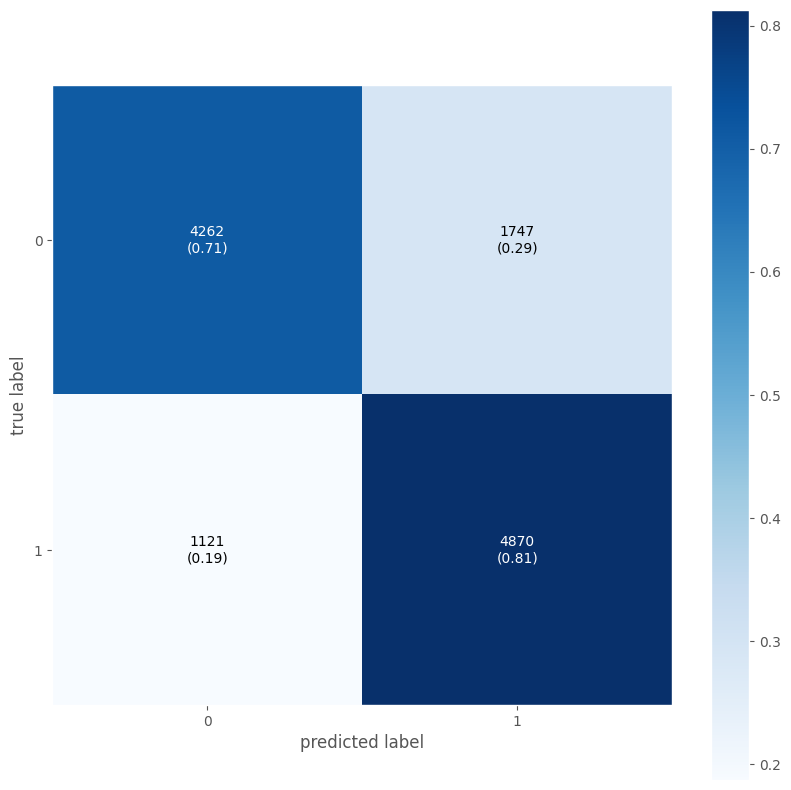

In [ ]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

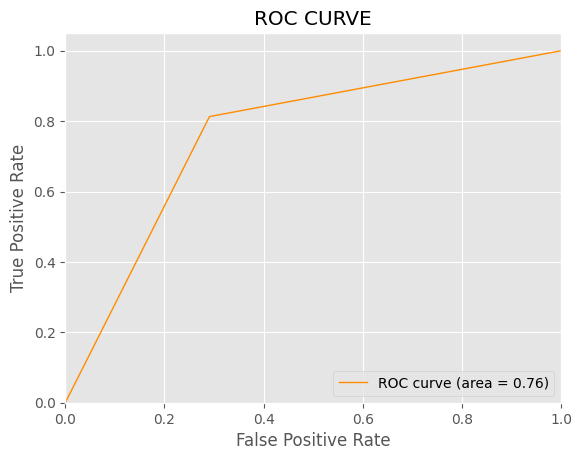

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()